# Exercise - Stripping Caps


#### Notation Commands

$$\newcommand{\Black}{\mathcal{B}}
\newcommand{\Blackcall}{\Black_{\mathrm{call}}}
\newcommand{\Blackput}{\Black_{\mathrm{put}}}
\newcommand{\EcondS}{\hat{S}_{\mathrm{conditional}}}
\newcommand{\Efwd}{\mathbb{E}^{T}}
\newcommand{\Ern}{\mathbb{E}^{\mathbb{Q}}}
\newcommand{\Tfwd}{T_{\mathrm{fwd}}}
\newcommand{\Tunder}{T_{\mathrm{bond}}}
\newcommand{\accint}{A}
\newcommand{\carry}{\widetilde{\cpn}}
\newcommand{\cashflow}{C}
\newcommand{\convert}{\phi}
\newcommand{\cpn}{c}
\newcommand{\ctd}{\mathrm{CTD}}
\newcommand{\disc}{Z}
\newcommand{\done}{d_{1}}
\newcommand{\dt}{\Delta t}
\newcommand{\dtwo}{d_{2}}
\newcommand{\flatvol}{\sigma_{\mathrm{flat}}}
\newcommand{\flatvolT}{\sigma_{\mathrm{flat},T}}
\newcommand{\float}{\mathrm{flt}}
\newcommand{\freq}{m}
\newcommand{\futprice}{\mathcal{F}(t,T)}
\newcommand{\futpriceDT}{\mathcal{F}(t+h,T)}
\newcommand{\futpriceT}{\mathcal{F}(T,T)}
\newcommand{\futrate}{\mathscr{f}}
\newcommand{\fwdprice}{F(t,T)}
\newcommand{\fwdpriceDT}{F(t+h,T)}
\newcommand{\fwdpriceT}{F(T,T)}
\newcommand{\fwdrate}{f}
\newcommand{\fwdvol}{\sigma_{\mathrm{fwd}}}
\newcommand{\fwdvolTi}{\sigma_{\mathrm{fwd},T_i}}
\newcommand{\grossbasis}{B}
\newcommand{\hedge}{\Delta}
\newcommand{\ivol}{\sigma_{\mathrm{imp}}}
\newcommand{\logprice}{p}
\newcommand{\logyield}{y}
\newcommand{\mat}{(n)}
\newcommand{\nargcond}{d_{1}}
\newcommand{\nargexer}{d_{2}}
\newcommand{\netbasis}{\tilde{\grossbasis}}
\newcommand{\normcdf}{\mathcal{N}}
\newcommand{\notional}{K}
\newcommand{\pfwd}{P_{\mathrm{fwd}}}
\newcommand{\pnl}{\Pi}
\newcommand{\price}{P}
\newcommand{\probexer}{\hat{\mathcal{P}}_{\mathrm{exercise}}}
\newcommand{\pvstrike}{K^*}
\newcommand{\refrate}{r^{\mathrm{ref}}}
\newcommand{\rrepo}{r^{\mathrm{repo}}}
\newcommand{\spotrate}{r}
\newcommand{\spread}{s}
\newcommand{\strike}{K}
\newcommand{\swap}{\mathrm{sw}}
\newcommand{\swaprate}{\cpn_{\swap}}
\newcommand{\tbond}{\mathrm{fix}}
\newcommand{\ttm}{\tau}
\newcommand{\value}{V}
\newcommand{\vega}{\nu}
\newcommand{\years}{\tau}
\newcommand{\yearsACT}{\tau_{\mathrm{act/360}}}
\newcommand{\yield}{Y}$$


# 1. Pricing Floors


### Data

The file `data/cap_curves_2025-06-30.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import log, sqrt, erf

FILE_NAME = 'cap_curves_2025-06-30.xlsx'
curve_data = pd.read_excel(FILE_NAME, sheet_name='rate curves 2025-06-30')
curve_data.head()

,tenor,swap rates,spot rates,discounts,forwards,flat vols,fwd vols
0,0.25,0.042353,0.042353,0.989523,NaN,NaN,NaN
1,0.50,0.040859,0.040852,0.979883,0.039351,0.156842,0.156842
2,0.75,0.039391,0.039372,0.971043,0.036414,0.180709,0.201708
3,1.00,0.038115,0.038083,0.962807,0.034217,0.204576,0.240464
4,1.25,0.036704,0.036653,0.955417,0.030938,0.242127,0.328341


### 1.1.

Recall that a floor is a portfolio of floorlets which
* depend on the realized interest rate one quarter before the expiration.
* each have the same strike interest rate.

Use Black's formula to price **just one floorlet**
* expiring at `T=3`
* struck at the `T=3` swap rate
* notional of `100`
* quarterly frequency


In [19]:
N = 100
T_pay = 3
freq = 4 # quarterly
accrual = 1/freq
t_fix = T_pay - accrual

row_3 = curve_data.set_index('tenor').loc[T_pay]
F = float(row_3['forwards'])
df_pay = float(row_3['discounts'])
sigma = float(row_3['flat vols'])
K = float(row_3['swap rates'])

def norm_cdf(x): return 0.5 * (1.0 + erf(x / sqrt(2.0)))

def black76_option_on_fwd(F, K, sigma, t_exp, option='call'):
    "Black-76 price of an optoon on an undiscounted forward"
    if t_exp <=0 or sigma <= 0:
        if option.lower() == 'call':
            return max(F-K, 0)
        else:            
            return max(K-F, 0)
    vol_sqrt_t = sigma * sqrt(t_exp)
    d1 = (log(F/K) + 0.5 * sigma**2 * t_exp) / vol_sqrt_t
    d2 = d1 - vol_sqrt_t
    if option.lower() == 'call':
        return F * norm_cdf(d1) - K * norm_cdf(d2)
    elif option.lower() == 'put':
        return K * norm_cdf(-d2) - F * norm_cdf(-d1)
    else:
        raise ValueError("option must be 'call' or 'put'")

def caplet_floorlet(notional, accrual, F, K, sigma, t_fix, df_pay, kind):
    "Price of a caplet or floorlet"
    if kind.lower() == 'caplet':
        black_fwd = black76_option_on_fwd(F, K, sigma, t_fix, option='call')
    elif kind.lower() == 'floorlet':
        black_fwd = black76_option_on_fwd(F, K, sigma, t_fix, option='put')
    else:
        raise ValueError("kind must be 'caplet' or 'floorlet'")
    return notional * accrual * df_pay * black_fwd

floorlet_pv = caplet_floorlet(
    notional = N, accrual = 1/freq, F=F, K=K, sigma=sigma, t_fix=t_fix, df_pay=df_pay, kind='floorlet'
)
print(f'Price of the floorlet: ${floorlet_pv:.2f}')

Price of the floorlet: $0.15


### 1.2.

Use Black's formula to price the entire floor with expiration of `T=3`.

The floor has floorlets at `quarterly` frequency, except the first quarter.


In [20]:
T_end = 3.0
accrual = 1/freq
df = curve_data.set_index('tenor').sort_index()
K = float(df.loc[T_end, 'swap rates'])
sigma = float(df.loc[T_end, 'flat vols'])

pay_dates = np.round(np.arange(0.75, T_end + 1e-12, accrual),2)

rows = []
pv_total = 0.0

for T_pay in pay_dates:
    F = float(df.loc[T_pay, 'forwards'])
    df_pay = float(df.loc[T_pay, 'discounts'])
    t_fix = float(T_pay - accrual) #fix one quarter prior

    pv_i = caplet_floorlet(
        notional = N, accrual = accrual, F=F, K=K, sigma=sigma, t_fix=t_fix, df_pay=df_pay, kind='floorlet'
    )

    pv_total += pv_i
    rows.append({
        'tenor': T_pay,
        'price': pv_i
    })

floor_table = pd.DataFrame(rows).set_index('tenor')
print(f'Price of the 3Y floor (sum of floorlets, skip first quarter): ${pv_total:.4f}')
floor_table

Price of the 3Y floor (sum of floorlets, skip first quarter): $1.3082


,price
tenor,
0.75,0.041221
1.00,0.075248
1.25,0.125061
1.50,0.142752
1.75,0.147216
2.00,0.149793
2.25,0.164223
2.50,0.156857
2.75,0.153865


# 2. Stripping Caps


### Data

Continue with the file `data/cap_curves_2025-06-30.xlsx`.


### 2.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.


In [21]:
def cap_price_flatvol_with_table(curve_data, T_end, notional=100.0, freq=4, skip_first=True):
    "Price ATM cap using Black-76 and the cap's flat vol sigma_flat(T_end)"
    accrual = 1/freq
    df = curve_data.set_index('tenor').sort_index()
    df.index = df.index.astype(float)

    K = float(df.loc[T_end, 'swap rates'])
    sigma = float(df.loc[T_end, 'flat vols'])

    start = 0.5
    if skip_first:
        start = 0.75
    pay_dates = np.round(np.arange(start, T_end + 1e-12, accrual),2)

    pv_total = 0.0
    rows = []
    for T_pay in pay_dates:
        F = float(df.loc[T_pay, 'forwards'])
        df_pay = float(df.loc[T_pay, 'discounts'])
        t_fix = float(T_pay - accrual) #fix one quarter prior

        pv_i = caplet_floorlet(
            notional = notional, accrual = accrual, F=F, K=K, sigma=sigma, t_fix=t_fix, df_pay=df_pay, kind='caplet'
        )

        pv_total += pv_i
        rows.append({
            'T_pay': T_pay,
            'caplet_pv': pv_i
        })
    out = pd.DataFrame(rows).set_index('T_pay')
    return pv_total, K, sigma, out

#Price caps across expirations
df = curve_data.copy()
df.index = df.index.astype(float)
Ts = df.loc[(df.index >= 0.5) & (df.index <= 10.0)].index.values
cap_prices = []
for T in Ts:
    cap_price, K, sigma, caplet_table = cap_price_flatvol_with_table(curve_data, T_end=T, notional=N, freq=freq, skip_first=True)
    cap_prices.append({
        'T_end': T,
        'Cap Price': cap_price,
        'ATM Strike (K)': K,
        'sigma (flat)': sigma
    })
cap_table = pd.DataFrame(cap_prices).set_index('T_end')
display(cap_table)

,Cap Price,ATM Strike (K),sigma (flat)
T_end,,,
1.0,0.059633,0.038115,0.204576
2.0,0.445035,0.034453,0.295615
3.0,0.949206,0.033568,0.294658
4.0,1.546900,0.033542,0.288628
5.0,2.154587,0.033852,0.274448
6.0,2.839079,0.034326,0.266091
7.0,3.513322,0.034847,0.255462
8.0,4.213696,0.035374,0.247002
9.0,4.938555,0.035879,0.240518


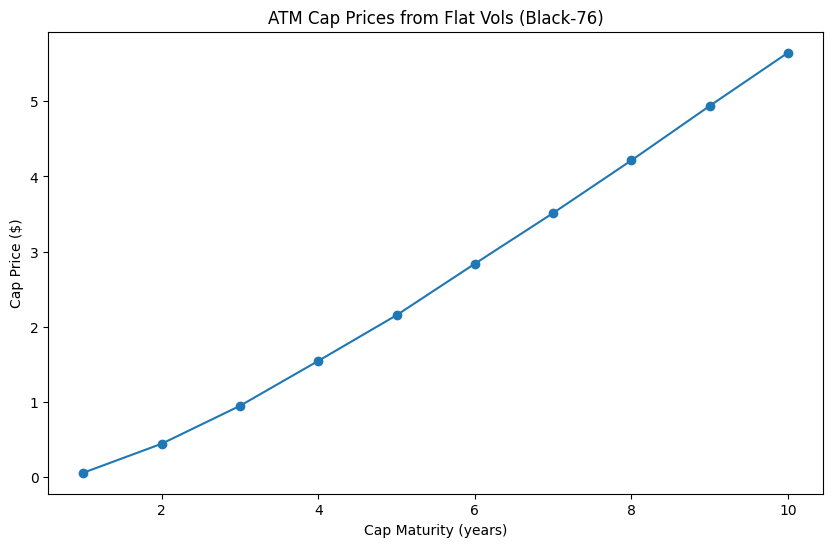

In [22]:
plt.figure(figsize=(10,6))
plt.plot(cap_table.index, cap_table['Cap Price'], marker='o')
plt.title('ATM Cap Prices from Flat Vols (Black-76)')
plt.xlabel('Cap Maturity (years)')
plt.ylabel('Cap Price ($)')
plt.show()

### 2.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.


In [23]:
def implied_black_vol_for_caplet(target_pv, notional, accrual, F, K, t_fix, df_pay, 
                                 vol_lo=1e-8, vol_hi=3.0, tol=1e-10, max_iter=200):
    "Solve for sigma such that Black-76 caplet PV matches target pv using bisection method"
    pv0 = caplet_floorlet(notional, accrual, F, K, 0.0, t_fix, df_pay, kind='caplet')
    if target_pv < pv0:
        return 0.0
    
    lo, hi = vol_lo, vol_hi
    for i in range(max_iter):
        mid = 0.5 * (lo + hi)
        pv_mid = caplet_floorlet(notional, accrual, F, K, mid, t_fix, df_pay, kind='caplet')
        if abs(pv_mid - target_pv) < tol:
            return mid
        if pv_mid < target_pv:
            lo = mid
        else:
            hi = mid
    return 0.5 * (lo + hi)

def cap_price_flatvol(curve_data, T_end, notional=100.0, freq=4, skip_first=True):
    "Price ATM cap using Black-76 and the cap's flat vol sigma_flat(T_end)"
    accrual = 1/freq
    df = curve_data.set_index('tenor').sort_index()
    df.index = df.index.astype(float)

    K = float(df.loc[T_end, 'swap rates'])
    sigma = float(df.loc[T_end, 'flat vols'])

    start = 0.5
    if skip_first:
        start = 0.75
    pay_dates = np.round(np.arange(start, T_end + 1e-12, accrual),2)

    pv = 0.0
    for T_pay in pay_dates:
        F = float(df.loc[T_pay, 'forwards'])
        df_pay = float(df.loc[T_pay, 'discounts'])
        t_fix = float(T_pay - accrual) #fix one quarter prior
        pv += caplet_floorlet(
            notional = notional, accrual = accrual, F=F, K=K, sigma=sigma, t_fix=t_fix, df_pay=df_pay, kind='caplet'
        )
    return pv, K, sigma

#Strip Caplet Prices & Forward Vols from Cap Prices:
def strip_caplets_and_forward_vols(curve_data, Tmin=0.5, Tmax=10.0, notional=100.0, freq=4):
    accrual = 1/freq
    df = curve_data.set_index('tenor').sort_index()
    df.index = df.index.astype(float)

    Ts = df.loc[(df.index >= Tmin) & (df.index <= Tmax)].index.to_numpy()
    
    cap_prices = {}
    cap_strikes = {}
    flat_vols = {}

    for T in Ts:
        pcap, K_T, sig_T = cap_price_flatvol(curve_data, T_end=T, notional=notional, freq=freq, skip_first=True)
        cap_prices[T] = pcap
        cap_strikes[T] = K_T
        flat_vols[T] = sig_T

    rows = []
    prev_T = None
    prev_cap  = None

    for T in Ts:
        T = float(T)
        pcap = cap_prices[T]

        if prev_T is None:
            caplet_pv = pcap
        else:
            caplet_pv = pcap - prev_cap
        
        F = float(df.loc[T, 'forwards'])
        df_pay = float(df.loc[T, 'discounts'])
        t_fix = float(T - accrual) #fix one quarter prior

        K = cap_strikes[T]

        sigma_fwd = implied_black_vol_for_caplet(
            target_pv=caplet_pv, notional=notional, accrual=accrual, 
            F=F, K=K, t_fix=t_fix, df_pay=df_pay)
        rows.append({
            'T_pay': T,
            'cap_price': pcap,
            'caplet_price_stripped': caplet_pv,
            'flat_vol(T)': flat_vols[T],
            'fwd_vol(T)': sigma_fwd,
            'K_ATM(T)': K,
            'F(T)': F
        })
        prev_T = T
        prev_cap = pcap

    out = pd.DataFrame(rows).set_index('T_pay')
    return out

strip = strip_caplets_and_forward_vols(curve_data, Tmin=0.5, Tmax=10.0, notional=N, freq=freq)
display(strip.head(10))

,cap_price,caplet_price_stripped,flat_vol(T),fwd_vol(T),K_ATM(T),F(T)
T_pay,,,,,,
0.50,0.000000,0.000000,0.156842,0.011719,0.040859,0.039351
0.75,0.019315,0.019315,0.180709,0.180709,0.039391,0.036414
1.00,0.059633,0.040318,0.204576,0.261713,0.038115,0.034217
1.25,0.129831,0.070198,0.242127,0.398883,0.036704,0.030938
1.50,0.220659,0.090827,0.268642,0.422990,0.035655,0.030280
1.75,0.327651,0.106992,0.285885,0.412018,0.034942,0.030542
2.00,0.445035,0.117385,0.295615,0.389942,0.034453,0.030919
2.25,0.562938,0.117902,0.299596,0.380168,0.034000,0.030248
2.50,0.686694,0.123756,0.299589,0.336250,0.033750,0.031414


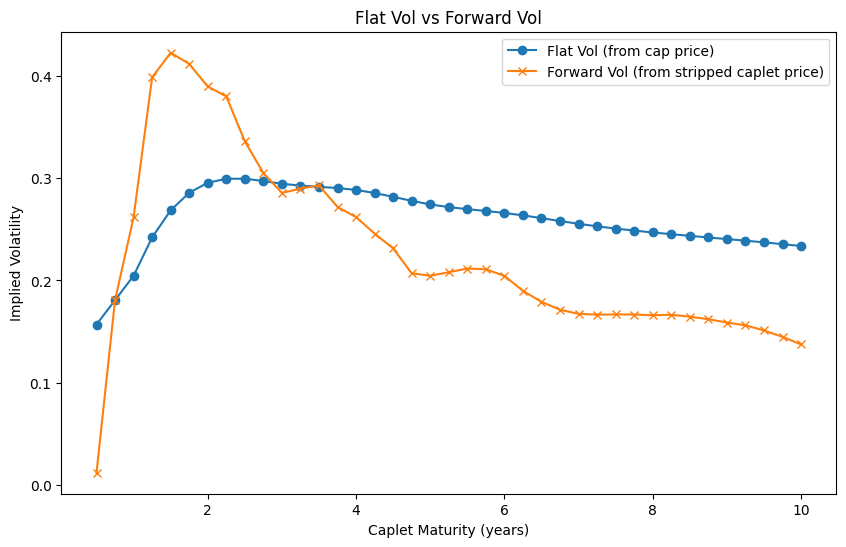

In [24]:
plt.figure(figsize=(10,6))
plt.plot(strip.index, strip['flat_vol(T)'], marker='o', label='Flat Vol (from cap price)')
plt.plot(strip.index, strip['fwd_vol(T)'], marker='x', label='Forward Vol (from stripped caplet price)')
plt.title('Flat Vol vs Forward Vol')
plt.xlabel('Caplet Maturity (years)')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()